## Yann Cauchepin

Hi, here is my documented jupyter notebook which respond to the test request.

## Requirements

Before even running the following script, please process by:

- [ ] Installing the interested librairies. You can comment the next script to not bide your time.

- [ ] Replacing dataset path toward your local repositories.

In [1]:
# !pip install scipy
# !pip install tqdm
# !pip install pandas
# !pip install numpy
# !pip install pyspark
# !pip install catboost
# !pip install shap
# !pip install pingouin
# !pip install seaborn
# !pip install torch
# !pip install captum
# !pip install sklearn
# !pip install mapie
# !pip install scikit-optimize
# !pip install pickle

In [2]:
metadata_path = "/media/yanncauchepin/ExternalDisk/Datasets/MachineLearningTables/lending_club/LCDataDictionary.xlsx"
data_path = "/media/yanncauchepin/ExternalDisk/Datasets/MachineLearningTables/lending_club/Loan_status_2007-2020Q3.csv"

Here

In [3]:
import pandas as pd
import numpy as np

In [4]:
metadata = pd.read_excel(metadata_path, index_col=0)
metadata = metadata.iloc[:-2,:]

In [5]:
#spark.stop

In [6]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("LendingClubDataProcessing") \
    .getOrCreate()

df_spark = spark.read.csv(data_path, header=True, inferSchema=True)
print(f"Number of data: {df_spark.count()}")

24/06/22 09:08:25 WARN Utils: Your hostname, yanncauchepincomputer resolves to a loopback address: 127.0.1.1; using 192.168.43.208 instead (on interface wlp2s0)
24/06/22 09:08:25 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/22 09:08:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Number of data: 2925493


In [7]:
print(f"Metadata features: {len(metadata.index)}")
print(f"Data features: {len(df_spark.columns)}")

outer_features = [feature for feature in df_spark.columns if feature not in metadata.index]

print(f"Unknown data features: {outer_features} ({len(outer_features)})")
df_spark = df_spark.drop(*outer_features)

Metadata features: 151
Data features: 142
Unknown data features: ['_c0', 'verification_status_joint', 'total_rev_hi_lim', 'revol_bal_joint', 'sec_app_fico_range_low', 'sec_app_fico_range_high', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util', 'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med'] (14)


In [8]:
features_to_drop = ['grade', 'sub_grade']
df_spark = df_spark.drop(*features_to_drop)

In [9]:
all_features = [feature for feature in df_spark.columns if feature != 'loan_status']

In [10]:
value_counts = df_spark.groupBy('loan_status').count()
value_rate = value_counts.count() / df_spark.count()
print(f"Number of distincts values: {value_counts.count()} - {value_rate:.2e} %")
value_counts.show()

Number of distincts values: 12 - 4.10e-06 %


+--------------------+-------+
|         loan_status|  count|
+--------------------+-------+
|          Fully Paid|1497783|
|                NULL|      1|
|     In Grace Period|  10028|
|Does not meet the...|   1988|
|         Charged Off| 362547|
|  Late (31-120 days)|  16154|
|             Current|1031016|
|Does not meet the...|    761|
|   Late (16-30 days)|   2719|
|             Default|    433|
|              Issued|   2062|
|            Oct-2015|      1|
+--------------------+-------+



In [11]:
'''
mapping = {
    'Fully Paid': 0,
    'Charged Off': 1,
    'Current': np.nan,
    'Late (31-120 days)': np.nan,
    'In Grace Period': np.nan,
    'Late (16-30 days)': np.nan,
    'Issued': np.nan,
    'Does not meet the credit policy. Status:Fully Paid': np.nan,
    'Does not meet the credit policy. Status:Charged Off': np.nan,
    'Default': np.nan,
    'Oct-2015': np.nan
}
'''

from pyspark.sql.functions import when
df_spark = df_spark.withColumn("loan_status", when(df_spark["loan_status"] == "Fully Paid", 0)
                   .when(df_spark["loan_status"] == "Charged Off", 1)
                   .otherwise(np.nan))

In [12]:
df_spark = df_spark.fillna({col: "nan" if df_spark.schema[col].dataType == 'string' else np.nan for col in all_features})

In [13]:
value_counts = df_spark.groupBy('loan_status').count()
value_rate = value_counts.count() / df_spark.count()
print(f"Number of distincts values: {value_counts.count()} - {value_rate:.2e} %")
value_counts.show()

Number of distincts values: 3 - 1.03e-06 %


+-----------+-------+
|loan_status|  count|
+-----------+-------+
|        0.0|1497783|
|        NaN|1065163|
|        1.0| 362547|
+-----------+-------+



In [14]:
df_spark.dtypes

[('id', 'string'),
 ('loan_amnt', 'int'),
 ('funded_amnt', 'int'),
 ('funded_amnt_inv', 'double'),
 ('term', 'string'),
 ('int_rate', 'string'),
 ('installment', 'double'),
 ('emp_title', 'string'),
 ('emp_length', 'string'),
 ('home_ownership', 'string'),
 ('annual_inc', 'string'),
 ('verification_status', 'string'),
 ('issue_d', 'string'),
 ('loan_status', 'double'),
 ('pymnt_plan', 'string'),
 ('url', 'string'),
 ('purpose', 'string'),
 ('title', 'string'),
 ('zip_code', 'string'),
 ('addr_state', 'string'),
 ('dti', 'string'),
 ('delinq_2yrs', 'double'),
 ('earliest_cr_line', 'string'),
 ('fico_range_low', 'string'),
 ('fico_range_high', 'int'),
 ('inq_last_6mths', 'int'),
 ('mths_since_last_delinq', 'int'),
 ('mths_since_last_record', 'int'),
 ('open_acc', 'int'),
 ('pub_rec', 'int'),
 ('revol_bal', 'int'),
 ('revol_util', 'string'),
 ('total_acc', 'string'),
 ('initial_list_status', 'string'),
 ('out_prncp', 'string'),
 ('out_prncp_inv', 'double'),
 ('total_pymnt', 'double'),
 ('

In [15]:
df_gb = df_spark.sample(fraction=0.05, seed=1)
print(f"Number of data: {df_gb.count()}")

Number of data: 145983


In [16]:
df_gb = df_gb.dropna(subset=['loan_status'])
print(f"Number of data: {df_gb.count()}")

Number of data: 92781


In [17]:
features_gb = df_gb.select(all_features)
features_collected_gb = features_gb.collect()
target_gb = df_gb.select('loan_status')
target_collected_gb = target_gb.collect()

24/06/22 09:10:00 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [18]:
X_gb = np.array([list(feature) for feature in features_collected_gb])

In [19]:
y_gb = np.array([feature['loan_status'] for feature in target_collected_gb])

In [20]:
X_gb.shape

(92781, 125)

In [21]:
y_gb.shape

(92781,)

In [22]:
categorical_features = [feature for (feature, dtype) in df_gb.dtypes if dtype=='string']

In [23]:
from catboost import Pool, CatBoostClassifier

pool = Pool(data=X_gb, label=y_gb, feature_names=all_features, cat_features=categorical_features)

catboost_model = CatBoostClassifier(iterations=100)
catboost_model.fit(pool)

Learning rate set to 0.5
0:	learn: 0.1319934	total: 227ms	remaining: 22.5s
1:	learn: 0.0766225	total: 314ms	remaining: 15.4s
2:	learn: 0.0388028	total: 419ms	remaining: 13.5s
3:	learn: 0.0303303	total: 492ms	remaining: 11.8s
4:	learn: 0.0235605	total: 556ms	remaining: 10.6s
5:	learn: 0.0206519	total: 617ms	remaining: 9.66s
6:	learn: 0.0195695	total: 679ms	remaining: 9.02s
7:	learn: 0.0189217	total: 741ms	remaining: 8.52s
8:	learn: 0.0175497	total: 802ms	remaining: 8.11s
9:	learn: 0.0175093	total: 860ms	remaining: 7.74s
10:	learn: 0.0167146	total: 917ms	remaining: 7.42s
11:	learn: 0.0158007	total: 990ms	remaining: 7.26s
12:	learn: 0.0157843	total: 1.05s	remaining: 7s
13:	learn: 0.0123135	total: 1.11s	remaining: 6.81s
14:	learn: 0.0123132	total: 1.16s	remaining: 6.55s
15:	learn: 0.0120829	total: 1.22s	remaining: 6.39s
16:	learn: 0.0108746	total: 1.28s	remaining: 6.23s
17:	learn: 0.0108745	total: 1.31s	remaining: 5.99s
18:	learn: 0.0108745	total: 1.36s	remaining: 5.8s
19:	learn: 0.0108743

In [24]:
import shap
explainer = shap.Explainer(catboost_model)
shap_values = explainer.shap_values(X_gb)

In [25]:
sum_over_feature = np.sum(np.abs(shap_values), axis=0)
feature_importance = pd.DataFrame(data=sum_over_feature, index=all_features, columns=['feature_importance'])
feature_importance = feature_importance[feature_importance['feature_importance']>0]
feature_importance = feature_importance.sort_values(by='feature_importance', ascending=False)
feature_importance.shape
feature_importance

,feature_importance
total_rec_prncp,417046.553348
recoveries,149158.378179
last_fico_range_low,135989.706385
loan_amnt,128005.130072
funded_amnt_inv,93815.640670
...,...
hardship_loan_status,1.477193
fico_range_low,0.305097
open_acc_6m,0.073228
verification_status,0.000302


In [26]:
feature_importance['cumulative_sum'] = feature_importance['feature_importance'].cumsum()
total_sum = feature_importance['feature_importance'].sum()
feature_importance['rate'] = feature_importance['cumulative_sum'] / total_sum
feature_importance

,feature_importance,cumulative_sum,rate
total_rec_prncp,417046.553348,4.170466e+05,0.302733
recoveries,149158.378179,5.662049e+05,0.411007
last_fico_range_low,135989.706385,7.021946e+05,0.509721
loan_amnt,128005.130072,8.301998e+05,0.602640
funded_amnt_inv,93815.640670,9.240154e+05,0.670740
...,...,...,...
hardship_loan_status,1.477193,1.377605e+06,1.000000
fico_range_low,0.305097,1.377605e+06,1.000000
open_acc_6m,0.073228,1.377605e+06,1.000000
verification_status,0.000302,1.377605e+06,1.000000


In [27]:
threshold = 0.9
selected_features = feature_importance[feature_importance['rate'] < threshold].index
selected_features
len(selected_features)

17

In [28]:
features_to_drop = [feature for feature in all_features if feature not in selected_features]
features_to_drop
len(features_to_drop)

108

In [29]:
df_spark = df_spark.drop(*features_to_drop)

In [30]:
df_spark.createOrReplaceTempView("lending_club")

In [31]:
def to_float(value):
    try:
        return float(value)
    except ValueError:
        return np.nan

from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf

to_float_udf = udf(to_float, FloatType())
df_spark = df_spark.withColumn("last_fico_range_high", to_float_udf(df_spark["last_fico_range_high"]))
df_spark = df_spark.withColumn("last_pymnt_amnt", to_float_udf(df_spark["last_pymnt_amnt"]))

In [32]:
sql_expression = """
CASE
    WHEN last_pymnt_d LIKE 'Jan-%' THEN CAST(SUBSTRING(last_pymnt_d, 5) AS FLOAT) + 0/12
    WHEN last_pymnt_d LIKE 'Feb-%' THEN CAST(SUBSTRING(last_pymnt_d, 5) AS FLOAT) + 1/12
    WHEN last_pymnt_d LIKE 'Mar-%' THEN CAST(SUBSTRING(last_pymnt_d, 5) AS FLOAT) + 2/12
    WHEN last_pymnt_d LIKE 'Apr-%' THEN CAST(SUBSTRING(last_pymnt_d, 5) AS FLOAT) + 3/12
    WHEN last_pymnt_d LIKE 'May-%' THEN CAST(SUBSTRING(last_pymnt_d, 5) AS FLOAT) + 4/12
    WHEN last_pymnt_d LIKE 'Jun-%' THEN CAST(SUBSTRING(last_pymnt_d, 5) AS FLOAT) + 5/12
    WHEN last_pymnt_d LIKE 'Jul-%' THEN CAST(SUBSTRING(last_pymnt_d, 5) AS FLOAT) + 6/12
    WHEN last_pymnt_d LIKE 'Aug-%' THEN CAST(SUBSTRING(last_pymnt_d, 5) AS FLOAT) + 7/12
    WHEN last_pymnt_d LIKE 'Sep-%' THEN CAST(SUBSTRING(last_pymnt_d, 5) AS FLOAT) + 8/12
    WHEN last_pymnt_d LIKE 'Oct-%' THEN CAST(SUBSTRING(last_pymnt_d, 5) AS FLOAT) + 9/12
    WHEN last_pymnt_d LIKE 'Nov-%' THEN CAST(SUBSTRING(last_pymnt_d, 5) AS FLOAT) + 10/12
    WHEN last_pymnt_d LIKE 'Dec-%' THEN CAST(SUBSTRING(last_pymnt_d, 5) AS FLOAT) + 11/12
    ELSE NULL
END AS last_pymnt_d_num
"""
df_spark = spark.sql(f"""
SELECT *, {sql_expression}
FROM lending_club
""")

df_spark = df_spark.drop("last_pymnt_d")
df_spark = df_spark.withColumnRenamed('last_pymnt_d_num', 'last_pymnt_d')

In [33]:
sql_expression = """
CASE
    WHEN last_credit_pull_d LIKE 'Jan-%' THEN CAST(SUBSTRING(last_credit_pull_d, 5) AS FLOAT) + 0/12
    WHEN last_credit_pull_d LIKE 'Feb-%' THEN CAST(SUBSTRING(last_credit_pull_d, 5) AS FLOAT) + 1/12
    WHEN last_credit_pull_d LIKE 'Mar-%' THEN CAST(SUBSTRING(last_credit_pull_d, 5) AS FLOAT) + 2/12
    WHEN last_credit_pull_d LIKE 'Apr-%' THEN CAST(SUBSTRING(last_credit_pull_d, 5) AS FLOAT) + 3/12
    WHEN last_credit_pull_d LIKE 'May-%' THEN CAST(SUBSTRING(last_credit_pull_d, 5) AS FLOAT) + 4/12
    WHEN last_credit_pull_d LIKE 'Jun-%' THEN CAST(SUBSTRING(last_credit_pull_d, 5) AS FLOAT) + 5/12
    WHEN last_credit_pull_d LIKE 'Jul-%' THEN CAST(SUBSTRING(last_credit_pull_d, 5) AS FLOAT) + 6/12
    WHEN last_credit_pull_d LIKE 'Aug-%' THEN CAST(SUBSTRING(last_credit_pull_d, 5) AS FLOAT) + 7/12
    WHEN last_credit_pull_d LIKE 'Sep-%' THEN CAST(SUBSTRING(last_credit_pull_d, 5) AS FLOAT) + 8/12
    WHEN last_credit_pull_d LIKE 'Oct-%' THEN CAST(SUBSTRING(last_credit_pull_d, 5) AS FLOAT) + 9/12
    WHEN last_credit_pull_d LIKE 'Nov-%' THEN CAST(SUBSTRING(last_credit_pull_d, 5) AS FLOAT) + 10/12
    WHEN last_credit_pull_d LIKE 'Dec-%' THEN CAST(SUBSTRING(last_credit_pull_d, 5) AS FLOAT) + 11/12
    ELSE NULL
END AS last_credit_pull_d_num
"""
df_spark = spark.sql(f"""
SELECT *, {sql_expression}
FROM lending_club
""")

df_spark = df_spark.drop("last_credit_pull_d")
df_spark = df_spark.withColumnRenamed('last_credit_pull_d_num', 'last_credit_pull_d')

In [34]:
df_spark = df_spark.drop("last_pymnt_d")
df_spark = df_spark.withColumnRenamed('last_pymnt_d_num', 'last_pymnt_d')

In [35]:
convert_to_float_rate = udf(lambda x: float(x.replace('%', '')) / 100, FloatType())
df_spark = df_spark.withColumn('int_rate', convert_to_float_rate(df_spark['int_rate']))

In [36]:
from pyspark.ml.feature import Imputer

numerical_selected_features = [feature for (feature, dtype) in df_spark.dtypes if (dtype!='string' and feature !='loan_status')]

imputer = Imputer(
    inputCols=numerical_selected_features,
    outputCols=numerical_selected_features
).setStrategy("mean")

df_spark = imputer.fit(df_spark).transform(df_spark)

In [37]:
# from pyspark.sql.functions import isnan
# for feature, dtype in df_spark.dtypes:
#     print("====================================")
#     print(f"FEATURE: {feature}")
#     if dtype=='string':
#         value_counts = df_spark.groupBy(feature).count()
#         value_rate = value_counts.count() / df_spark.count()
#         print(f"Number of distincts values: {value_counts.count()} - {value_rate:.2e} %")
#         value_counts.show()
#     nan_count = df_spark.filter(df_spark[feature].isNull() | isnan(df_spark[feature])).count()
#     nan_rate = nan_count / df_spark.count()
#     print(f"{nan_count} NaN - {nan_rate:.2e} %")
#     print("\n")

In [38]:
df = df_spark.sample(fraction=0.005, seed=1)
print(f"Number of data: {df.count()}")
df_labeled = df.dropna(subset=['loan_status'])
print(f"Number of labeled data: {df_labeled.count()}")

Number of data: 14518


Number of labeled data: 9247


In [39]:
from pyspark.sql.functions import isnan
df_nan = df.filter(isnan(df['loan_status']))
print(f"Number of NaN data: {df_nan.count()}")

Number of NaN data: 5271


In [40]:
features = [feature for feature in list(df_spark.columns) if feature != 'loan_status']

In [106]:
features_collected = df_labeled.select(features).collect()
target_collected = df_labeled.select('loan_status').collect()
X_labeled = np.array([list(feature) for feature in features_collected], dtype=float)
y_labeled = np.array([feature['loan_status'] for feature in target_collected], dtype=float)
y_labeled = y_labeled.astype(int)

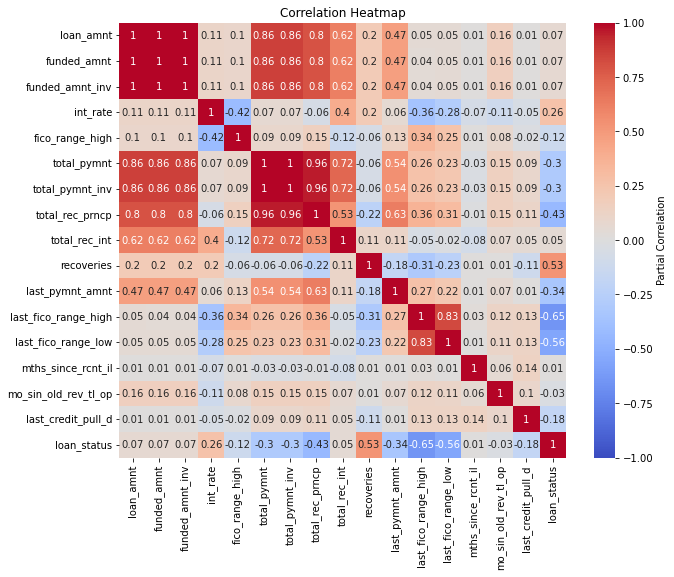

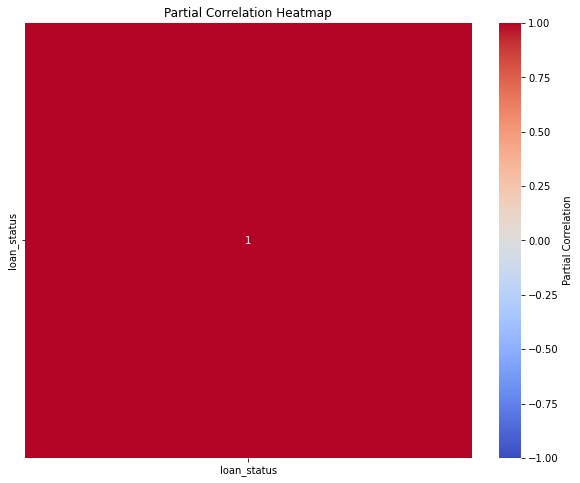

In [121]:
import pingouin as pg
import seaborn as sns

features_pcorr = pd.DataFrame(X_labeled.astype(float), columns=features)
df_combined['loan_status'] = y_labeled

corr_matrix = df_combined.corr(numeric_only=False).round(2)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, cbar_kws={'label': 'Partial Correlation'})
plt.title('Correlation Heatmap')
plt.show()

pcorr_matrix = df_combined.pcorr().round(2)
plt.figure(figsize=(10, 8))
sns.heatmap(pcorr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, cbar_kws={'label': 'Partial Correlation'})
plt.title('Partial Correlation Heatmap')
plt.show()

In [42]:
features_collected = df_nan.select(features).collect()
X_unlabeled = np.array([list(feature) for feature in features_collected], dtype=float)

In [43]:
classes_ = np.unique(y_labeled)

In [44]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset
from captum.attr import IntegratedGradients
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from mapie.classification import MapieClassifier
from sklearn.calibration import CalibratedClassifierCV
from skopt import BayesSearchCV
import matplotlib.pyplot as plt

torch.manual_seed(1)
torch.cuda.manual_seed_all(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

class MLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_layer_sizes, activation_name, p_dropout):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_layer_sizes = hidden_layer_sizes
        if isinstance(self.hidden_layer_sizes, str):
            self.hidden_layer_sizes = eval(self.hidden_layer_sizes)
        self.activation_name = activation_name
        self.p_dropout = p_dropout
        if activation_name == "Relu":
            self.activation = nn.ReLU()
        elif activation_name == "Sigmoid":
            self.activation = nn.Sigmoid()
        elif activation_name == "Softmax":
            self.activation = nn.Softmax(dim=1)
        elif activation_name == "Tanh":
            self.activation = nn.Tanh()
        elif activation_name == "Leaky_relu":
            self.activation = nn.LeakyReLU()
        else:
            raise ValueError(f'Unsupported activation: {self.activation_name}')
        layers = []
        layers.append(nn.Linear(self.input_size, self.hidden_layer_sizes[0]))
        layers.append(self.activation)
        for i in range(len(self.hidden_layer_sizes) - 1):
            layers.append(nn.Linear(self.hidden_layer_sizes[i], self.hidden_layer_sizes[i + 1]))
            layers.append(self.activation)
            layers.append(nn.Dropout(p=self.p_dropout))
        layers.append(nn.Linear(self.hidden_layer_sizes[-1], self.output_size))
        self.model = nn.Sequential(*layers)
        self.sigmoid = nn.Sigmoid()
        

    def forward_proba(self, X):
        output = self.model(X)
        output = self.sigmoid(output)
        return output.float()
    
    
    def forward(self, X):
        output = self.model(X)
        output = self.sigmoid(output)
        return output


class MLPEstimatorSklearn():
    def __init__(self, **params):
        self.input_size = params.get("input_size")
        self.output_size = params.get("output_size")
        self.hidden_layer_sizes = params.get("hidden_layer_sizes", (60, 60))
        self.activation_name = params.get("activation_name", "Relu")
        self.loss = params.get("loss", "binary_cross_entropy")
        self.optimizer_name = params.get("optimizer_name", "Adam")
        self.learning_rate = params.get("learning_rate", 1e-3)
        self.batch_size = params.get("batch_size", 50)
        self.weight_decay = params.get("weight_decay", 0)
        self.p_dropout = params.get("p_dropout", 0.2)
        self.early_stopping = params.get("early_stopping", True)
        self.epochs = params.get("epochs", 200)
        self.patience = params.get("patience", 10)
        self.verbose = params.get("verbose", True)
        self.classes_ = classes_

        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model = MLP(self.input_size, self.output_size, self.hidden_layer_sizes, self.activation_name, self.p_dropout).to(self.device)

        if self.loss == "binary_cross_entropy":
            self.criterion = nn.BCELoss()
        else:
            raise ValueError(f"Unsupported loss: {self.loss}")

        if self.optimizer_name == "SGD":
            self.optimizer = optim.SGD(self.model.parameters(), lr=self.learning_rate, momentum=0.9, weight_decay=self.weight_decay)
        elif self.optimizer_name == "Adam":
            self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        else:
            raise ValueError(f"Unsupported optimizer: {self.optimizer}")
            
    def next_batch(self, inputs, targets, batchSize):
        inputs_tensor = torch.from_numpy(inputs).float()
        targets_tensor = torch.from_numpy(targets).float().unsqueeze(1)
        for i in range(0, inputs_tensor.shape[0], batchSize):
            yield (inputs_tensor[i:i + batchSize], targets_tensor[i:i + batchSize])

    def augment_data(self, X_unlabeled, noise_level=0.1):
        noise = noise_level * torch.randn_like(X_unlabeled)
        return X_unlabeled + noise
            
    def fit(self, X, y, X_unlabeled=None):
        self.classes_ = np.unique(y)
        running_losses_1 = list()
        if self.early_stopping:
            best_loss = float('inf')
            count = 0
        if self.verbose:
            epoch_iterator_1 = tqdm(range(self.epochs), desc="Supervised training ; epochs", unit="epoch")
        else:
            epoch_iterator_1 = range(self.epochs)
        for epoch in epoch_iterator_1:
            samples = 0
            train_loss = 0.0
            self.model.train(True)
            for i, (batchX, batchY) in enumerate(self.next_batch(X, y, self.batch_size)):
                batchX = batchX.to(self.device)
                batchY = batchY.to(self.device)
                batchY.requires_grad = True
                self.optimizer.zero_grad()
                outputs = self.model(batchX)
                loss = self.criterion(outputs, batchY)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
                samples += batchY.size(0)
            running_loss = train_loss / samples
            running_losses_1.append(running_loss)
            if self.verbose:
                epoch_iterator_1.set_postfix(train_loss=running_loss)
            if self.early_stopping:
                if running_loss < best_loss:
                    best_loss = running_loss
                    count = 0
                else:
                    count += 1
                if count >= self.patience:
                    break
        if self.verbose:
            epoch_iterator_1.close()
        self.running_losses_1 = [loss for loss in running_losses_1 if loss <= best_loss]
        if X_unlabeled is not None:
            best_loss = float('inf')
            running_losses_2 = list()
            X_unlabeled = torch.from_numpy(X_unlabeled).float()
            augmented_X_unlabeled = self.augment_data(X_unlabeled)
            self.model.eval()
            with torch.no_grad():
                pseudo_labels = self.model(X_unlabeled)
                pseudo_labels = (pseudo_labels > 0.5).float().squeeze()
            
            X_combined = torch.cat((torch.from_numpy(X).float(), augmented_X_unlabeled.cpu()), 0).to(self.device)
            y_combined = torch.cat((torch.from_numpy(y).float().squeeze(), pseudo_labels), 0).to(self.device)

            if self.verbose:
                epoch_iterator_2 = tqdm(range(self.epochs), desc="Semi-supervised training ; epochs", unit="epoch")
            else:
                epoch_iterator_2 = range(self.epochs)
            for epoch in epoch_iterator_2:
                samples = 0
                train_loss = 0.0
                self.model.train(True)
                dataset = TensorDataset(X_combined, y_combined)
                for i, (batchX, batchY) in enumerate(self.next_batch(X, y, self.batch_size)):
                    batchX = batchX.to(self.device)
                    batchY = batchY.to(self.device)
                    batchY.requires_grad = True
                    self.optimizer.zero_grad()
                    outputs = self.model(batchX)
                    loss = self.criterion(outputs, batchY)
                    loss.backward()
                    self.optimizer.step()
                    train_loss += loss.item()
                    samples += batchY.size(0)
                running_loss = train_loss / samples
                running_losses_2.append(running_loss)
                if self.verbose:
                    epoch_iterator_2.set_postfix(train_loss=running_loss)
                if self.early_stopping:
                    if running_loss < best_loss:
                        best_loss = running_loss
                        count = 0
                    else:
                        count += 1
                    if count >= self.patience:
                        break
            if self.verbose:
                epoch_iterator_2.close()
            self.running_losses_2 = [loss for loss in running_losses_2 if loss <= best_loss]
        return self

    def predict(self, X):
        self.model.eval()
        X = torch.from_numpy(X).float().to(self.device)
        y_pred = self.model.forward(X)
        if self.device == "cpu":
            y_pred = y_pred.cpu().detach().numpy()
        else:
            y_pred = y_pred.detach().numpy()
        return (y_pred > 0.5).astype(int)

    def predict_proba(self, X):
        self.model.eval()
        X = torch.from_numpy(X).float().to(self.device)
        y_proba = self.model.forward_proba(X)
        if self.device == "cpu":
            y_proba = y_proba.cpu().detach().numpy().astype(float)
        else:
            y_proba = y_proba.detach().numpy().astype(float)
        y_proba = y_proba.squeeze().astype(np.float32)
        return np.column_stack((1 - y_proba, y_proba))

    def get_params(self, deep=True):
        params = {
            "input_size": self.input_size,
            "output_size": self.output_size,
            "hidden_layer_sizes": self.hidden_layer_sizes,
            "activation_name": self.activation_name,
            "loss": self.loss,
            "optimizer_name": self.optimizer_name,
            "learning_rate": self.learning_rate,
            "batch_size": self.batch_size,
            "weight_decay": self.weight_decay,
            "p_dropout": self.p_dropout,
            "early_stopping": self.early_stopping,
            "epochs": self.epochs,
            "patience": self.patience,
            "verbose": self.verbose
        }
        return params

    def set_params(self, **params):
        for key, value in params.items():
            if hasattr(self, key):
                setattr(self, key, value)
        return self

    def get_mlp(self):
        return self.model
    
class MLPBinaryClassifier():
    def __init__(self, X, y, split_test, X_unlabeled=None, **params):
        self.model = MLPEstimatorSklearn(**params)
        self.X = X
        self.X_unlabeled = X_unlabeled
        self.y = y
        
        self.y = MLPBinaryClassifier.float_to_class(self.y).ravel()
        
        self.split_test = split_test
        self.split_data()
        
        self.standardize(self.X_train_cal)
        self.X_train_standard = self.standardize_X(self.X_train)
        self.X_cal_standard = self.standardize_X(self.X_cal)
        if isinstance(self.X_unlabeled, np.ndarray):
            self.X_unlabeled_standard = self.standardize_X(self.X_unlabeled)
        else :
            self.X_unlabeled_standard = None
        self.y_train_standard = self.y_train
        self.y_cal_standard = self.y_cal.reshape(-1,1)


    @staticmethod
    def float_to_class(y):
        threshold = 0.5
        return (y >= threshold).astype(int)
    
    def split_data(self):
        self.X_train_cal, self.X_test, self.y_train_cal, self.y_test = train_test_split(
            self.X, self.y, test_size=self.split_test, shuffle=True, random_state=1, stratify=self.y)
        self.X_train, self.X_cal, self.y_train, self.y_cal = train_test_split(
            self.X_train_cal, self.y_train_cal, test_size=0.25, shuffle=True, random_state=1, stratify=self.y_train_cal)

    def standardize(self, X):
        self.scaler_X_train = StandardScaler()
        self.scaler_X_train.fit(X)         


    def standardize_X(self, X):
        X_new = self.scaler_X_train.transform(X)
        return X_new
    


    def bayes_search(self, param_bayes, n_iter, n_points=1, cv=5, scoring='accuracy',
                 verbose=3, n_jobs=1) :
        cv = StratifiedKFold(n_splits=cv, shuffle=True, random_state=1)
        bayes_search = BayesSearchCV(self.model, param_bayes, n_iter=n_iter,
                                     n_points=n_points, cv=cv, scoring=scoring,
                                     verbose=verbose, return_train_score=True,
                                     n_jobs=n_jobs, random_state=1)
        bayes_search.fit(self.X_train_standard, self.y_train_standard)
        results_df = pd.DataFrame(bayes_search.cv_results_)
        self.model = bayes_search.best_estimator_
        print(f'Best hyperparameters bayes search : {bayes_search.best_params_}')
        return results_df

    def randomized_search(self, param_randomized, n_iter, cv=5, scoring='accuracy',
                      verbose=3, n_jobs=1) :
        cv = StratifiedKFold(n_splits=cv, shuffle=True, random_state=1)
        randomized_search = RandomizedSearchCV(self.model, param_randomized,
                                               n_iter=n_iter, cv=cv, scoring=scoring,
                                               verbose=verbose, return_train_score=True,
                                               n_jobs=n_jobs, random_state=1)
        randomized_search.fit(self.X_train_standard, self.y_train_standard)
        results_df = pd.DataFrame(randomized_search.cv_results_)
        self.model = randomized_search.best_estimator_
        print(f'Best hyperparameters randomized search : {randomized_search.best_params_}')
        return results_df

    def fit(self, method="lac"):
        self.model.fit(self.X_train_standard, self.y_train_standard, self.X_unlabeled_standard)
        self.model_mapie = MapieClassifier(estimator=self.model, cv="prefit", method=method)
        self.model_mapie.fit(self.X_cal_standard, self.y_cal_standard)

    def predict(self, X, alpha=0.05):
        X_standard = self.standardize_X(X)
        y_pred, y_ps = self.model_mapie.predict(X_standard, alpha=alpha)
        return y_pred, y_ps

    @staticmethod
    def compute_metrics(metric, y_true, y_pred):
        y_pred = MLPBinaryClassifier.float_to_class(y_pred)
        accuracy = metrics.accuracy_score(y_true, y_pred)
        precision = metrics.precision_score(y_true, y_pred, average='weighted', zero_division=0)
        recall = metrics.recall_score(y_true, y_pred, average='weighted')
        f1 = metrics.f1_score(y_true, y_pred, average='weighted')
        metrics_dict = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1': f1,
        }
        if metric != 'all':
            metrics_dict = {metric: metrics_dict[metric]}
        return metrics_dict


    def model_performance(self, metric='all'):
        y_pred_train, _ = self.predict(self.X_train)
        scores_train = MLPBinaryClassifier.compute_metrics(metric, self.y_train, y_pred_train)
        y_pred_test, _ = self.predict(self.X_test)
        scores_test = MLPBinaryClassifier.compute_metrics(metric, self.y_test, y_pred_test)
        data = {}
        for key, value in scores_train.items():
            data['Train Set - '+key] = [value]
        for key, value in scores_test.items():
            data['Test Set - '+key] = [value]
        df_scores = pd.DataFrame(data=data).T
        df_scores.columns = ['Scores']
        return df_scores

    def model_performance_test(self, X_test, y_test, metric='all'):
        y_pred_test, _ = self.predict(X_test)
        scores_test = MLPBinaryClassifier.compute_metrics(metric, y_test, y_pred_test)
        data = {}
        for key, value in scores_test.items():
            data['Test Set - '+key] = [value]
        df_scores = pd.DataFrame(data=data).T
        df_scores.columns = ['Scores']
        return df_scores

    def receiver_operating_characteristics(self):
        y_pred_test, _ = self.predict(self.X_test)
        fpr, tpr, thresholds = metrics.roc_curve(self.y_test, y_pred_test)
        plt.plot(fpr, tpr)
        plt.title("Receiver Operating Characteristics")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.show()

    def compute_integrated_gradients(self, X, baseline=None, steps=50):
        def preprocess_input(X):
            return torch.tensor(X, dtype=torch.float32)
        input_tensor = preprocess_input(X)
        if baseline is None:
            baseline = torch.zeros_like(input_tensor)
        integrated_gradients = IntegratedGradients(self.model.get_mlp())
        attributions = integrated_gradients.attribute(input_tensor, baseline, target=0, n_steps=steps)
        attributions_df = pd.DataFrame(attributions.cpu().detach().numpy(), columns=features)
        avg_attributions = attributions_df.mean(axis=0)
        avg_abs_attributions = avg_attributions.abs()
        def custom_minmax_scaler(data, feature_range=(0, 100)):
            min_val = np.min(data)
            max_val = np.max(data)
            if max_val - min_val == 0:
                return np.zeros_like(data) if feature_range[0] == 0 else np.full_like(data, feature_range[0])
            scale = (feature_range[1] - feature_range[0]) / (max_val - min_val)
            min_range = feature_range[0]
            scaled_data = scale * (data - min_val) + min_range
            return scaled_data
        normalized_data = custom_minmax_scaler(avg_abs_attributions.values.reshape(-1, 1)).astype(float)
        np.set_printoptions(suppress=True, precision=2)
        normalized_attributions = pd.DataFrame(normalized_data, columns=['attribution'], index=features)
        sorted_attributions = normalized_attributions.sort_values(by="attribution", ascending=False)
        return sorted_attributions

In [45]:
from scipy.stats import loguniform, uniform
from skopt.space import Real

params = {    
    "init" : {
        "input_size" : len(features),
        "output_size" : 1,
        "hidden_layer_sizes" : (60,60),
        "activation_name" : "Relu",
        "optimizer_name" : "Adam",
        "learning_rate" : 1e-3,
        "batch_size" : 50,
        "weight_decay" : 0,
        "p_dropout" : 0.3,
        "loss" : "binary_cross_entropy",
        "early_stopping" : True,
        "epochs" : 200,
        "patience" : 10,
        "verbose" : True
    },
    "randomized": {
        "hidden_layer_sizes" : [(10,),(50,),(100,),(10,10),(50,50),(60,60),(100,50),(100,100),(100,50,25)],
        "activation_name" :  ["Relu", "Sigmoid", "Tanh", "Leaky_relu", "Softmax"],
        "learning_rate" : loguniform(1e-4, 1e-1),
        "batch_size" : list(np.arange(10,500, 10)),
        "optimizer_name" : ["Adam", "SGD"],
        "alpha" : np.logspace(-3,0,19),
        "weight_decay" : loguniform(1e-5, 1),
        "p_dropout" : uniform(0, 0.4)   
    },
    "bayes": {
        "hidden_layer_sizes" : ["(10,)","(50,)","(100,)","(10,10)","(50,50)","(60,60)","(100,50)","(100,100)","(100,50,25)"],
        "activation_name" :  ["Relu", "Sigmoid", "Tanh", "Leaky_relu", "Softmax"],
        "learning_rate" : Real(1e-4, 1e-1, prior='log-uniform'),
        "batch_size" : list(np.arange(10,500, 10)),
        "optimizer_name" : ["Adam", "SGD"],
        "alpha" : np.logspace(-3,0,19),
        "weight_decay" : Real(1e-5, 1, prior='log-uniform'),
        "p_dropout" : Real(0, 0.4, prior='uniform')
    }
}

model_mlp = MLPBinaryClassifier(X=X_labeled, y=y_labeled, X_unlabeled=X_unlabeled, split_test=0.2, **params["init"])

In [46]:
n_iter = 5
n_points=1
cv=5
scoring='accuracy'
verbose=3
n_jobs=-1

In [47]:
# model_mlp.bayes_search(
#     param_bayes=params['bayes'],
#     n_iter=n_iter,
#     n_points=n_points,
#     cv=cv,
#     scoring=scoring,
#     n_jobs=n_jobs
# )

In [48]:
model_mlp.randomized_search(
    param_randomized=params['randomized'],
    n_iter=n_iter,
    cv=cv,
    scoring=scoring,
    n_jobs=n_jobs
)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


Supervised training ; epochs:   0%|          | 0/200 [00:00<?, ?epoch/s]53epoch/s, train_loss=5.18e-6]

[CV 2/5] END activation_name=Softmax, alpha=0.01, batch_size=260, hidden_layer_sizes=(100,), learning_rate=0.034588581370567514, optimizer_name=SGD, p_dropout=0.2740878001587038, weight_decay=0.00010525948689799706;, score=(train=1.000, test=0.996) total time=   5.2s


Supervised training ; epochs:  90%|█████████ | 180/200 [00:08<00:00, 22.66epoch/s, train_loss=1.53e-6]

[CV 4/5] END activation_name=Leaky_relu, alpha=0.1, batch_size=90, hidden_layer_sizes=(60, 60), learning_rate=0.0002755926764027377, optimizer_name=Adam, p_dropout=0.15863229091841047, weight_decay=0.0008700690210600529;, score=(train=1.000, test=0.997) total time=   7.9s


Supervised training ; epochs:  97%|█████████▋| 194/200 [00:09<00:00, 21.34epoch/s, train_loss=1.05e-6]


[CV 1/5] END activation_name=Softmax, alpha=0.01, batch_size=260, hidden_layer_sizes=(100,), learning_rate=0.034588581370567514, optimizer_name=SGD, p_dropout=0.2740878001587038, weight_decay=0.00010525948689799706;, score=(train=1.000, test=0.997) total time=   9.2s
[CV 3/5] END activation_name=Softmax, alpha=0.01, batch_size=260, hidden_layer_sizes=(100,), learning_rate=0.034588581370567514, optimizer_name=SGD, p_dropout=0.2740878001587038, weight_decay=0.00010525948689799706;, score=(train=1.000, test=0.996) total time=   9.1s


Supervised training ; epochs:  50%|█████     | 100/200 [00:04<00:04, 22.52epoch/s, train_loss=6.6e-6] 

[CV 2/5] END activation_name=Leaky_relu, alpha=0.1, batch_size=90, hidden_layer_sizes=(60, 60), learning_rate=0.0002755926764027377, optimizer_name=Adam, p_dropout=0.15863229091841047, weight_decay=0.0008700690210600529;, score=(train=1.000, test=0.995) total time=  10.1s
[CV 3/5] END activation_name=Leaky_relu, alpha=0.1, batch_size=90, hidden_layer_sizes=(60, 60), learning_rate=0.0002755926764027377, optimizer_name=Adam, p_dropout=0.15863229091841047, weight_decay=0.0008700690210600529;, score=(train=1.000, test=0.996) total time=  10.2s


Supervised training ; epochs:  65%|██████▌   | 130/200 [00:06<00:03, 20.64epoch/s, train_loss=3.49e-6]

[CV 5/5] END activation_name=Leaky_relu, alpha=0.1, batch_size=90, hidden_layer_sizes=(60, 60), learning_rate=0.0002755926764027377, optimizer_name=Adam, p_dropout=0.15863229091841047, weight_decay=0.0008700690210600529;, score=(train=0.998, test=0.998) total time=  11.4s


Supervised training ; epochs:  74%|███████▍  | 148/200 [00:07<00:02, 20.51epoch/s, train_loss=2.39e-6]

[CV 1/5] END activation_name=Leaky_relu, alpha=0.1, batch_size=90, hidden_layer_sizes=(60, 60), learning_rate=0.0002755926764027377, optimizer_name=Adam, p_dropout=0.15863229091841047, weight_decay=0.0008700690210600529;, score=(train=1.000, test=0.995) total time=  12.1s


Supervised training ; epochs:  50%|█████     | 100/200 [00:04<00:04, 20.24epoch/s, train_loss=5.04e-6]

[CV 4/5] END activation_name=Softmax, alpha=0.01, batch_size=260, hidden_layer_sizes=(100,), learning_rate=0.034588581370567514, optimizer_name=SGD, p_dropout=0.2740878001587038, weight_decay=0.00010525948689799706;, score=(train=1.000, test=0.997) total time=   7.5s


Supervised training ; epochs:   6%|▌         | 12/200 [00:01<00:26,  7.12epoch/s, train_loss=0.000178]

[CV 5/5] END activation_name=Softmax, alpha=0.01, batch_size=260, hidden_layer_sizes=(100,), learning_rate=0.034588581370567514, optimizer_name=SGD, p_dropout=0.2740878001587038, weight_decay=0.00010525948689799706;, score=(train=1.000, test=0.999) total time=   6.2s


Supervised training ; epochs:  28%|██▊       | 55/200 [00:10<00:28,  5.17epoch/s, train_loss=1e-5]   

[CV 1/5] END activation_name=Sigmoid, alpha=0.03162277660168379, batch_size=80, hidden_layer_sizes=(100, 50), learning_rate=0.003584739875476995, optimizer_name=Adam, p_dropout=0.357842665401539, weight_decay=2.6620797194541587e-05;, score=(train=0.999, test=0.995) total time=   9.3s


Supervised training ; epochs:  32%|███▎      | 65/200 [00:08<00:16,  8.15epoch/s, train_loss=1.64e-5]

[CV 3/5] END activation_name=Tanh, alpha=0.21544346900318823, batch_size=50, hidden_layer_sizes=(100, 100), learning_rate=0.002352959348061621, optimizer_name=SGD, p_dropout=0.05615477543809351, weight_decay=9.783797277120768e-05;, score=(train=0.998, test=0.996) total time=  12.4s


Supervised training ; epochs:   2%|▏         | 3/200 [00:00<00:06, 29.58epoch/s, train_loss=0.000529]]

[CV 2/5] END activation_name=Sigmoid, alpha=0.03162277660168379, batch_size=80, hidden_layer_sizes=(100, 50), learning_rate=0.003584739875476995, optimizer_name=Adam, p_dropout=0.357842665401539, weight_decay=2.6620797194541587e-05;, score=(train=1.000, test=0.995) total time=  10.6s


Supervised training ; epochs:  10%|▉         | 19/200 [00:00<00:05, 33.90epoch/s, train_loss=7.63e-5]]

[CV 4/5] END activation_name=Tanh, alpha=0.21544346900318823, batch_size=50, hidden_layer_sizes=(100, 100), learning_rate=0.002352959348061621, optimizer_name=SGD, p_dropout=0.05615477543809351, weight_decay=9.783797277120768e-05;, score=(train=1.000, test=0.995) total time=  13.8s


Supervised training ; epochs:   2%|▏         | 3/200 [00:00<00:08, 24.19epoch/s, train_loss=0.000633]

[CV 3/5] END activation_name=Sigmoid, alpha=0.03162277660168379, batch_size=80, hidden_layer_sizes=(100, 50), learning_rate=0.003584739875476995, optimizer_name=Adam, p_dropout=0.357842665401539, weight_decay=2.6620797194541587e-05;, score=(train=1.000, test=0.996) total time=  11.1s
[CV 1/5] END activation_name=Tanh, alpha=0.21544346900318823, batch_size=50, hidden_layer_sizes=(100, 100), learning_rate=0.002352959348061621, optimizer_name=SGD, p_dropout=0.05615477543809351, weight_decay=9.783797277120768e-05;, score=(train=1.000, test=0.999) total time=  16.4s


Supervised training ; epochs:  28%|██▊       | 56/200 [00:01<00:04, 31.40epoch/s, train_loss=1.75e-5]

[CV 2/5] END activation_name=Tanh, alpha=0.21544346900318823, batch_size=50, hidden_layer_sizes=(100, 100), learning_rate=0.002352959348061621, optimizer_name=SGD, p_dropout=0.05615477543809351, weight_decay=9.783797277120768e-05;, score=(train=1.000, test=0.996) total time=  16.4s


Supervised training ; epochs:  55%|█████▌    | 110/200 [00:10<00:08, 10.87epoch/s, train_loss=1.24e-5]
Supervised training ; epochs: 100%|█| 200/200 [00:04<00:00, 47.58epo


Best hyperparameters randomized search : {'activation_name': 'Leaky_relu', 'alpha': 0.31622776601683794, 'batch_size': 430, 'hidden_layer_sizes': (100, 50, 25), 'learning_rate': 0.0001972606689184097, 'optimizer_name': 'SGD', 'p_dropout': 0.26866163896885376, 'weight_decay': 0.0011453530979564342}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation_name,param_alpha,param_batch_size,param_hidden_layer_sizes,param_learning_rate,param_optimizer_name,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,10.346584,1.443283,0.002567,0.000291,Leaky_relu,0.1,90,"(60, 60)",0.000276,Adam,...,0.996575,0.001050,5,1.000000,0.999775,1.000000,0.999549,0.998197,0.999504,0.000674
1,7.451467,1.572430,0.002419,0.000319,Softmax,0.01,260,"(100,)",0.034589,SGD,...,0.997296,0.000987,2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
2,14.774245,1.538422,0.002528,0.000573,Tanh,0.215443,50,"(100, 100)",0.002353,SGD,...,0.996755,0.001223,3,1.000000,1.000000,0.998197,1.000000,1.000000,0.999639,0.000721
3,10.065618,0.732336,0.001694,0.000491,Sigmoid,0.031623,80,"(100, 50)",0.003585,Adam,...,0.996575,0.001550,4,0.998873,1.000000,1.000000,0.998423,0.999549,0.999369,0.000628
4,4.776841,0.538071,0.001599,0.000324,Leaky_relu,0.316228,430,"(100, 50, 25)",0.000197,SGD,...,0.997656,0.001223,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


In [49]:
model_mlp.model.get_params()

{'input_size': 16,
 'output_size': 1,
 'hidden_layer_sizes': (100, 50, 25),
 'activation_name': 'Leaky_relu',
 'loss': 'binary_cross_entropy',
 'optimizer_name': 'SGD',
 'learning_rate': 0.0001972606689184097,
 'batch_size': 430,
 'weight_decay': 0.0011453530979564342,
 'p_dropout': 0.26866163896885376,
 'early_stopping': True,
 'epochs': 200,
 'patience': 10,
 'verbose': True}

In [50]:
model_mlp.fit()

Supervised training ; epochs:  96%|▉| 192/200 [00:04<00:00, 44.99epo
Semi-supervised training ; epochs:  40%|▍| 79/200 [00:01<00:02, 46.3
/home/yanncauchepin/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [51]:
model_mlp.model_performance()

,Scores
Train Set - Accuracy,0.966108
Train Set - Precision,0.965755
Train Set - Recall,0.966108
Train Set - F1,0.965789
Test Set - Accuracy,0.961081
Test Set - Precision,0.960632
Test Set - Recall,0.961081
Test Set - F1,0.960716


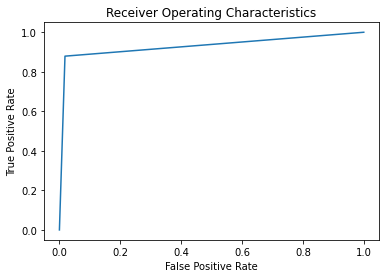

In [52]:
model_mlp.receiver_operating_characteristics()

In [53]:
df_test = df_spark.sample(fraction=0.05, seed=30)
df_test = df_test.dropna(subset=['loan_status'])
features_collected = df_test.select(features).collect()
X_test = np.array([list(feature) for feature in features_collected])
target_collected = df_test.select('loan_status').collect()
y_test = np.array([feature['loan_status'] for feature in target_collected])
y_test = y_test.astype(int)

In [54]:
model_mlp.model_performance_test(X_test, y_test)

,Scores
Test Set - Accuracy,0.964156
Test Set - Precision,0.963724
Test Set - Recall,0.964156
Test Set - F1,0.963776


In [55]:
single_value_collected = df_spark.sample(withReplacement=False, fraction=0.0001, seed=1).limit(1).collect()[0]
single_value = np.array([value for key, value in single_value_collected.asDict().items() if key != 'loan_status']).reshape(1,-1).astype(float)
single_value_target = np.array([value for key, value in single_value_collected.asDict().items() if key == 'loan_status'])

In [62]:
single_value

array([[18000.  , 12325.  , 12325.  ,     0.12,   739.  , 16341.39,
        16341.39, 12325.  ,  4016.39,     0.  ,   271.56,   739.  ,
          735.  ,     0.  ,     0.  ,  2016.92]])

In [63]:
model_mlp.compute_integrated_gradients(single_value)

,attribution
total_pymnt_inv,100.000000
total_pymnt,86.161525
total_rec_prncp,70.410990
loan_amnt,27.327880
funded_amnt,11.441951
funded_amnt_inv,8.073740
last_fico_range_high,4.452166
last_fico_range_low,2.839816
last_pymnt_amnt,2.109614
total_rec_int,1.141622


In [58]:
# import pickle
# with open('lending_club_mlp_binary_classifier.pkl', 'wb') as file:
#     pickle.dump(model_mlp, file)

[CV 5/5] END activation_name=Tanh, alpha=0.21544346900318823, batch_size=50, hidden_layer_sizes=(100, 100), learning_rate=0.002352959348061621, optimizer_name=SGD, p_dropout=0.05615477543809351, weight_decay=9.783797277120768e-05;, score=(train=1.000, test=0.996) total time=  14.9s
[CV 2/5] END activation_name=Leaky_relu, alpha=0.31622776601683794, batch_size=430, hidden_layer_sizes=(100, 50, 25), learning_rate=0.0001972606689184097, optimizer_name=SGD, p_dropout=0.26866163896885376, weight_decay=0.0011453530979564342;, score=(train=1.000, test=0.996) total time=   4.1s
[CV 1/5] END activation_name=Leaky_relu, alpha=0.31622776601683794, batch_size=430, hidden_layer_sizes=(100, 50, 25), learning_rate=0.0001972606689184097, optimizer_name=SGD, p_dropout=0.26866163896885376, weight_decay=0.0011453530979564342;, score=(train=1.000, test=0.999) total time=   5.6s
[CV 4/5] END activation_name=Leaky_relu, alpha=0.31622776601683794, batch_size=430, hidden_layer_sizes=(100, 50, 25), learning_ra